# End-to-End MLFlow Pipeline:
- [Databricks Link](https://jixjiastorage.blob.core.windows.net/blog-resources/end-to-end-dl-with-mlflow/End-to-End%20Deep%20Learning%20with%20MLflow%20(EN).html)

### 한글 폰트 다운로드/설정

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 23 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 2s (6,106 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 128288 files and di

### MLFlow설치와 Databricks Tracking Server 설정

In [ ]:
!pip install mlflow
!databricks configure --host https://community.cloud.databricks.com/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.5/147.5 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 KB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17

In [ ]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, Reshape, InputLayer
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import mlflow
from mlflow.exceptions import MlflowException
from mlflow.tracking import MlflowClient
from mlflow.keras import log_model

import os
import glob
import numpy as np
import cv2
import pickle
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

from google.colab import drive


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/legume.dater0t@icloud.com/sign_lang")

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/1948595066832280', creation_time=1679879137929, experiment_id='1948595066832280', last_update_time=1680174746631, lifecycle_stage='active', name='/Users/legume.dater0t@icloud.com/sign_lang', tags={'mlflow.experiment.sourceName': '/Users/legume.dater0t@icloud.com/sign_lang',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'legume.dater0t@icloud.com',
 'mlflow.ownerId': '8740233206362604'}>

In [ ]:
# train loss 그리는 함수
def view_loss(history):
    plt.clf()
    plt.semilogy(history.history['loss'], label="train_loss")
    plt.title('model loss(train)')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    return plt

# confusion matrix 그리는 함수
def view_conf_mat(conf):

    fig, ax = plt.subplots(1, 1, figsize=(20, 20))

    ConfusionMatrixDisplay(conf, display_labels=labels).plot(ax=ax)
    
    return fig

In [ ]:
def train_with_mlflow(run_name, model, compile_kwargs, fit_kwargs, optional_params={}):
    with mlflow.start_run(run_name=run_name) as run:
        model.compile(**compile_kwargs)

        history = model.fit(**fit_kwargs)

        print("Logging parameters")
        ## MLFlow tracking
        for param_key, param_value in {**compile_kwargs, **fit_kwargs, **optional_params}.items():
            if param_key not in ['x', 'y', 'validation_data', 'test_data']:
                print(f'logging {param_key}')
                mlflow.log_param(param_key, param_value)

        print("Logging metrics")
        for key, values in history.history.items():
            print(f'logging {key}')
            for i, v in enumerate(values):
                mlflow.log_metric(key, v, step=i)

        # Sketch Loss
        fig = view_loss(history)

        fig.savefig('train_validation_loss.png')
        mlflow.log_artifact('train_validation_loss.png')

        print('Logging test eval data')
        if optional_params:
            X_test = optional_params['test_data'][0]
            y_test = optional_params['test_data'][1]

            y_pred = model.predict(X_test)
            y_pred = np.argmax(y_pred, axis=1)

            y_expected = np.argmax(y_test, axis=1)

            report = classification_report(
                y_expected,
                y_pred,
                output_dict=False,
                target_names=labels
            )
            with open('report.txt', 'w') as f:
                f.write(report)
            mlflow.log_artifact('report.txt')

            y_expected_label = [labels[i] for i in y_expected]
            y_pred_label = [labels[i] for i in y_pred]

            conf_mat = confusion_matrix(
                y_expected_label, 
                y_pred_label,
                labels=labels)
            
            plt = view_conf_mat(conf_mat)
            plt.savefig('confusion.png')
            mlflow.log_artifact('confusion.png')

        # save model and reload model
        print("Logging model")

        model.save_weights('model_weights.h5', overwrite=True)

        model = create_model()

        model.load_weights('model_weights.h5')
        
        mlflow.log_artifact('model_weights.h5')
        # log_model(model, 'keras_model')

        return run



## 데이터 불러오기 / Train, val, test 데이터 설정

In [ ]:
def data_call(AUG_NUM, FRAME_NUM, JITTER=None):
    # if JITTER:
    #     X = np.load(f'/content/drive/MyDrive/수어 영상 데이터/final_X_{AUG_NUM}_f{FRAME_NUM}_jit{JITTER}.npy')
    #     y = np.load(f'/content/drive/MyDrive/수어 영상 데이터/final_y_{AUG_NUM}_f{FRAME_NUM}_jit{JITTER}.npy')
    # else:
    #     X = np.load(f'/content/drive/MyDrive/수어 영상 데이터/final_X_{AUG_NUM}_f{FRAME_NUM}.npy')
    #     y = np.load(f'/content/drive/MyDrive/수어 영상 데이터/final_y_{AUG_NUM}_f{FRAME_NUM}.npy')

    # set the common part of the file names
    print('Loading Data...')
    file_name = f'/content/drive/MyDrive/수어 영상 데이터/final_X_{AUG_NUM}_f{FRAME_NUM}'

    # add the _jit{JITTER} suffix when JITTER is True
    if JITTER:
        file_name += f'_jit{JITTER}'

    # load the X and y data

    X = np.load(file_name + '.npy')
    y = np.load(file_name.replace('X', 'y') + '.npy')

    df_labels = pd.read_csv('/content/drive/MyDrive/수어 영상 데이터/final_y_labels.csv', index_col=0)
    labels = df_labels['val'].tolist()

    print('Splitting Train/Test...')
    # set aside 20% of train and test data for evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y,
        test_size=0.2, shuffle = True, random_state = 8, stratify=y)

    print('Splitting Train/Val...')

    # Use the same function above for the validation set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
        test_size=0.25, random_state= 8, stratify=y_train) # 0.25 x 0.8 = 0.2

    print('Reshaping')
    X_train = X_train.reshape(-1, FRAME_NUM, 21, 3)
    X_val = X_val.reshape(-1, FRAME_NUM, 21, 3)
    X_test = X_test.reshape(-1, FRAME_NUM, 21, 3)

    X_train = X_train[:, :, :, :2]
    X_val = X_val[:, :, :, :2]
    X_test = X_test[:, :, :, :2]

    X_train = X_train.reshape(X_train.shape[:-2] + (-1,))
    X_val = X_val.reshape(X_val.shape[:-2] + (-1,))
    X_test = X_test.reshape(X_test.shape[:-2] + (-1,))

    print(X_train.shape, X_val.shape, X_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test, labels

    

In [ ]:
import numpy as np

# Create an example array
arr = np.random.rand(100, 60, 21, 2)

# Merge the last two axes
merged_arr = arr.reshape(arr.shape[:-2] + (-1,))
merged_arr.shape

(100, 60, 42)

## tmp model

In [ ]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(60, 63)))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))


In [ ]:
model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 128)           98304     
                                                                 
 dropout_4 (Dropout)         (None, 60, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 60, 256)           394240    
                                                                 
 dropout_5 (Dropout)         (None, 60, 256)           0         
                                                                 
 lstm_4 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 100)              

In [ ]:
log_dir = os.path.join('logs/train/base_with_dropout')
tb_callback = TensorBoard(log_dir=log_dir)
model.fit(X_train, y_train, epochs=1000, callbacks=[tb_callback], validation_data=(X_val, y_val))

## Model Experiments

### Experiment 1

Epoch 1/100
186/186 [==============================] - 4s 11ms/step - loss: 3.5293 - categorical_accuracy: 0.0717 - val_loss: 3.1020 - val_categorical_accuracy: 0.1071
Epoch 2/100
186/186 [==============================] - 2s 9ms/step - loss: 2.8767 - categorical_accuracy: 0.1535 - val_loss: 2.6518 - val_categorical_accuracy: 0.1980
Epoch 3/100
186/186 [==============================] - 2s 10ms/step - loss: 2.4510 - categorical_accuracy: 0.2271 - val_loss: 2.1067 - val_categorical_accuracy: 0.3015
Epoch 4/100
186/186 [==============================] - 2s 10ms/step - loss: 2.0960 - categorical_accuracy: 0.3072 - val_loss: 1.8223 - val_categorical_accuracy: 0.3621
Epoch 5/100
186/186 [==============================] - 1s 8ms/step - loss: 1.8308 - categorical_accuracy: 0.3736 - val_loss: 1.6886 - val_categorical_accuracy: 0.4328
Epoch 6/100
186/186 [==============================] - 1s 7ms/step - loss: 1.6669 - categorical_accuracy: 0.4278 - val_loss: 1.4084 - val_categorical_accuracy: 0.

2023/03/27 04:00:32 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Logging model


2023/03/27 04:00:43 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.4.6+cuda11.cudnn86) contains a local version label (+cuda11.cudnn86). MLflow logged a pip requirement for this package as 'jaxlib==0.4.6' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Logging test eval data
62/62 [==============================] - 1s 3ms/step


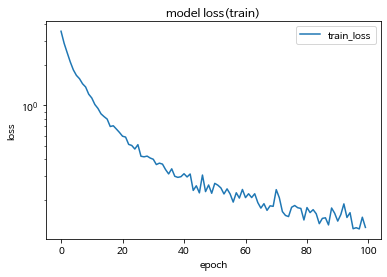

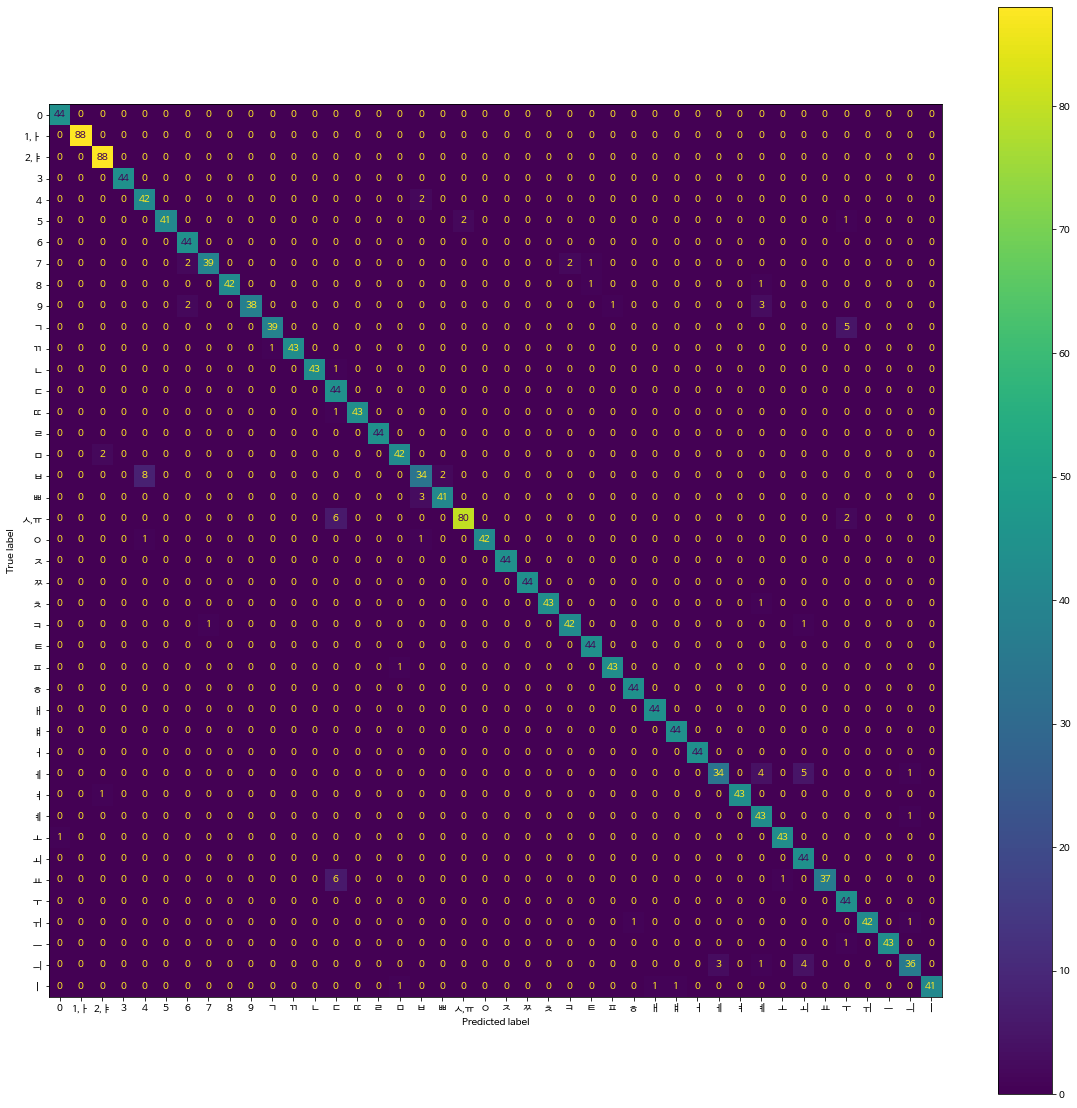

In [ ]:
AUG_NUM = 10
FRAME_NUM = 60

X_train, X_val, X_test, y_train, y_val, y_test = data_call(AUG_NUM, FRAME_NUM)

model = Sequential([
    InputLayer(input_shape=(60,63 )),
    Dropout(0.2),
    LSTM(160, input_shape=[60, 63]),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dense(y.shape[1], activation='softmax')
])

# Compile hyperparameter
compile_kwargs = {
    "optimizer": 'Adam', 
    "loss": 'categorical_crossentropy',
    "metrics": ['categorical_accuracy'],
}

# fit hyperparameter
fit_kwargs = {
    "x": X_train, 
    "y": y_train,
    "epochs": 100,
    "validation_data": (X_val, y_val)
}

optional_params = {
    "test_data": (X_test, y_test),
    "aug_num": 10
}

run_name = 'base_model'
run = train_with_mlflow(run_name, model, compile_kwargs, fit_kwargs, optional_params)

In [ ]:
model = Sequential([
    InputLayer(input_shape=(60,63 )),
    Dropout(0.2),
    LSTM(160, input_shape=[60, 63]),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dense(y.shape[1], activation='softmax')
])
# Compile hyperparameter
compile_kwargs = {
    "optimizer": 'Adam', 
    "loss": 'categorical_crossentropy',
    "metrics": ['categorical_accuracy'],
}

# fit hyperparameter
fit_kwargs = {
    "x": X_train, 
    "y": y_train,
    "epochs": 100,
    "validation_data": (X_val, y_val)
}

optional_params = {
    "test_data": (X_test, y_test),
    "aug_num": 10
}

run_name = 'base_model'
run = train_with_mlflow(run_name, model, compile_kwargs, fit_kwargs, optional_params)

### Experiment 2

In [ ]:
AUG_NUM = 100
FRAME_NUM = 30

X_train, X_val, X_test, y_train, y_val, y_test, labels = data_call(AUG_NUM, FRAME_NUM)


In [ ]:
model = Sequential([
    InputLayer(input_shape=(FRAME_NUM,63 )),
    Dropout(0.2),
    LSTM(160, input_shape=[FRAME_NUM, 63]),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])
# Compile hyperparameter
compile_kwargs = {
    "optimizer": 'Adam', 
    "loss": 'categorical_crossentropy',
    "metrics": ['categorical_accuracy'],
}

# fit hyperparameter
fit_kwargs = {
    "x": X_train, 
    "y": y_train,
    "epochs": 100,
    "validation_data": (X_val, y_val)
}

optional_params = {
    "test_data": (X_test, y_test),
    "aug_num": AUG_NUM,
    "frame_num": FRAME_NUM
}

run_name = f'base_model_aug_{AUG_NUM}_frame_{FRAME_NUM}'
run = train_with_mlflow(run_name, model, compile_kwargs, fit_kwargs, optional_params)

### Experiment 3

In [ ]:
AUG_NUM = 100
FRAME_NUM = 30


X_train, X_val, X_test, y_train, y_val, y_test, labels = data_call(AUG_NUM, FRAME_NUM)



In [ ]:
# Enable TPU
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.12.0
Running on TPU  ['10.108.13.154:8470']


In [ ]:
# to TPU

def create_model():
    model = Sequential([
    InputLayer(input_shape=(FRAME_NUM,63 )),
    LSTM(160, return_sequences=True, activation='relu', input_shape=[FRAME_NUM, 63]),
    Dropout(0.5),
    LSTM(120, return_sequences=False, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
    ])

    return model


In [ ]:
with tpu_strategy.scope():
    model = create_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_9 (Dropout)         (None, 30, 63)            0         
                                                                 
 lstm_6 (LSTM)               (None, 30, 160)           143360    
                                                                 
 dropout_10 (Dropout)        (None, 30, 160)           0         
                                                                 
 lstm_7 (LSTM)               (None, 120)               134880    
                                                                 
 dropout_11 (Dropout)        (None, 120)               0         
                                                                 
 dense_6 (Dense)             (None, 100)               12100     
                                                                 
 dense_7 (Dense)             (None, 42)               

In [ ]:
# Compile hyperparameter
compile_kwargs = {
    "optimizer": 'Adam', 
    "loss": 'categorical_crossentropy',
    "metrics": ['categorical_accuracy'],
}

# fit hyperparameter
fit_kwargs = {
    "x": X_train, 
    "y": y_train,
    'batch_size': 256,
    "epochs": 1,
    "validation_data": (X_val, y_val)
}

optional_params = { 
    "test_data": (X_test, y_test),
    "aug_num": AUG_NUM,
    "frame_num": FRAME_NUM
}

# run_name = f'double_LSTM_aug_{AUG_NUM}_frame_{FRAME_NUM}'
run_name = 'TPU_test'
run = train_with_mlflow(run_name, model, compile_kwargs, fit_kwargs, optional_params)

In [ ]:
model.predict(X_test)

569/569 [==============================] - 13s 17ms/step


array([[3.96411903e-10, 3.05477699e-10, 6.80462561e-11, ...,
        1.18928805e-08, 3.24585017e-07, 2.37192467e-06],
       [1.57992985e-09, 4.13222110e-13, 4.92481931e-08, ...,
        1.79131205e-14, 2.07142692e-10, 3.90366992e-12],
       [1.57770444e-13, 1.50762948e-17, 1.19782391e-15, ...,
        1.84727015e-28, 2.68153262e-20, 6.84723298e-24],
       ...,
       [1.31082356e-09, 3.38598579e-06, 1.32011763e-11, ...,
        8.22311918e-14, 2.03775556e-07, 3.50168875e-07],
       [1.03708629e-19, 6.64457303e-21, 7.79292510e-21, ...,
        1.08741239e-12, 3.62520875e-28, 1.34531522e-27],
       [7.32653352e-05, 1.05329425e-08, 1.16243427e-06, ...,
        2.94405611e-09, 1.08401532e-09, 2.06576035e-04]], dtype=float32)

### Experiment 4

In [ ]:
AUG_NUM = 100
FRAME_NUM = 15
SHIFT_VAL = 0.3
ROTATE_VAL = 0.0
SCALE_VAL = 0.5
JITTER_AMOUNT = 5
EPOCH = 250
BATCH_SIZE = 128



In [ ]:
def data_call(AUG_NUM, FRAME_NUM, JITTER=None):
    X = np.load('/content/drive/MyDrive/수어 영상 데이터/final_X_100_f30_jit5_2D.npy')
    y = np.load('/content/drive/MyDrive/수어 영상 데이터/final_y_100_f30_jit5_2D.npy')

    df_labels = pd.read_csv('/content/drive/MyDrive/수어 영상 데이터/final_y_labels.csv', index_col=0)
    labels = df_labels['val'].tolist()

    print('Splitting Train/Test...')
    # set aside 20% of train and test data for evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y,
        test_size=0.2, shuffle = True, random_state = 8, stratify=y)

    print('Splitting Train/Val...')

    # Use the same function above for the validation set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
        test_size=0.25, random_state= 8, stratify=y_train) # 0.25 x 0.8 = 0.2

    print('Reshaping')
    X_train = X_train.reshape(-1, FRAME_NUM, 21, 3)
    X_val = X_val.reshape(-1, FRAME_NUM, 21, 3)
    X_test = X_test.reshape(-1, FRAME_NUM, 21, 3)

    # select 15 frame
    X_train = X_train[:, ::2, :, :]
    X_val = X_val[:, ::2, :, :]
    X_test = X_test[:, ::2, :, :]

    X_train = X_train[:, :, :, :2]
    X_val = X_val[:, :, :, :2]
    X_test = X_test[:, :, :, :2]

    X_train = X_train.reshape(X_train.shape[:-2] + (-1,))
    X_val = X_val.reshape(X_val.shape[:-2] + (-1,))
    X_test = X_test.reshape(X_test.shape[:-2] + (-1,))

    print(X_train.shape, X_val.shape, X_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test, labels

    

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, labels = data_call(AUG_NUM, FRAME_NUM, JITTER_AMOUNT)

Splitting Train/Test...
Splitting Train/Val...
Reshaping
(27540, 15, 42) (9180, 15, 42) (9180, 15, 42)


In [ ]:
# to TPU

def create_model():
    model = Sequential([
    InputLayer(input_shape=(FRAME_NUM,X_train.shape[-1])),
    Dropout(0.2),
    LSTM(160, return_sequences=True, activation='relu', input_shape=[FRAME_NUM, X_train.shape[-1]]),
    Dropout(0.5),
    LSTM(120, return_sequences=False, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
    ])

    return model

with tpu_strategy.scope():
    model = create_model()
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_18 (Dropout)        (None, 15, 42)            0         
                                                                 
 lstm_12 (LSTM)              (None, 15, 160)           129920    
                                                                 
 dropout_19 (Dropout)        (None, 15, 160)           0         
                                                                 
 lstm_13 (LSTM)              (None, 120)               134880    
                                                                 
 dropout_20 (Dropout)        (None, 120)               0         
                                                                 
 dense_12 (Dense)            (None, 100)               12100     
                                                                 
 dense_13 (Dense)            (None, 42)               

Epoch 1/250
216/216 [==============================] - 16s 44ms/step - loss: 2.7717 - categorical_accuracy: 0.1963 - val_loss: 1.1924 - val_categorical_accuracy: 0.5979
Epoch 2/250
216/216 [==============================] - 5s 22ms/step - loss: 1.4246 - categorical_accuracy: 0.4856 - val_loss: 0.7869 - val_categorical_accuracy: 0.6886
Epoch 3/250
216/216 [==============================] - 5s 21ms/step - loss: 1.1776 - categorical_accuracy: 0.5656 - val_loss: 0.6973 - val_categorical_accuracy: 0.7149
Epoch 4/250
216/216 [==============================] - 5s 23ms/step - loss: 1.0385 - categorical_accuracy: 0.6207 - val_loss: 0.5547 - val_categorical_accuracy: 0.8306
Epoch 5/250
216/216 [==============================] - 5s 22ms/step - loss: 0.9203 - categorical_accuracy: 0.6657 - val_loss: 0.5668 - val_categorical_accuracy: 0.8034
Epoch 6/250
216/216 [==============================] - 5s 21ms/step - loss: 0.8564 - categorical_accuracy: 0.6931 - val_loss: 0.4963 - val_categorical_accuracy

Logging test eval data
287/287 [==============================] - 4s 10ms/step
Logging model


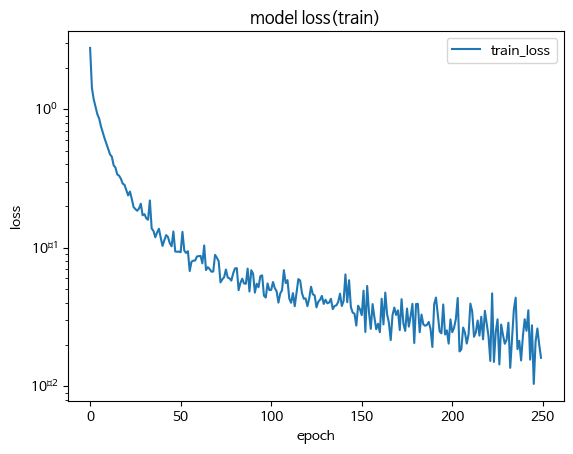

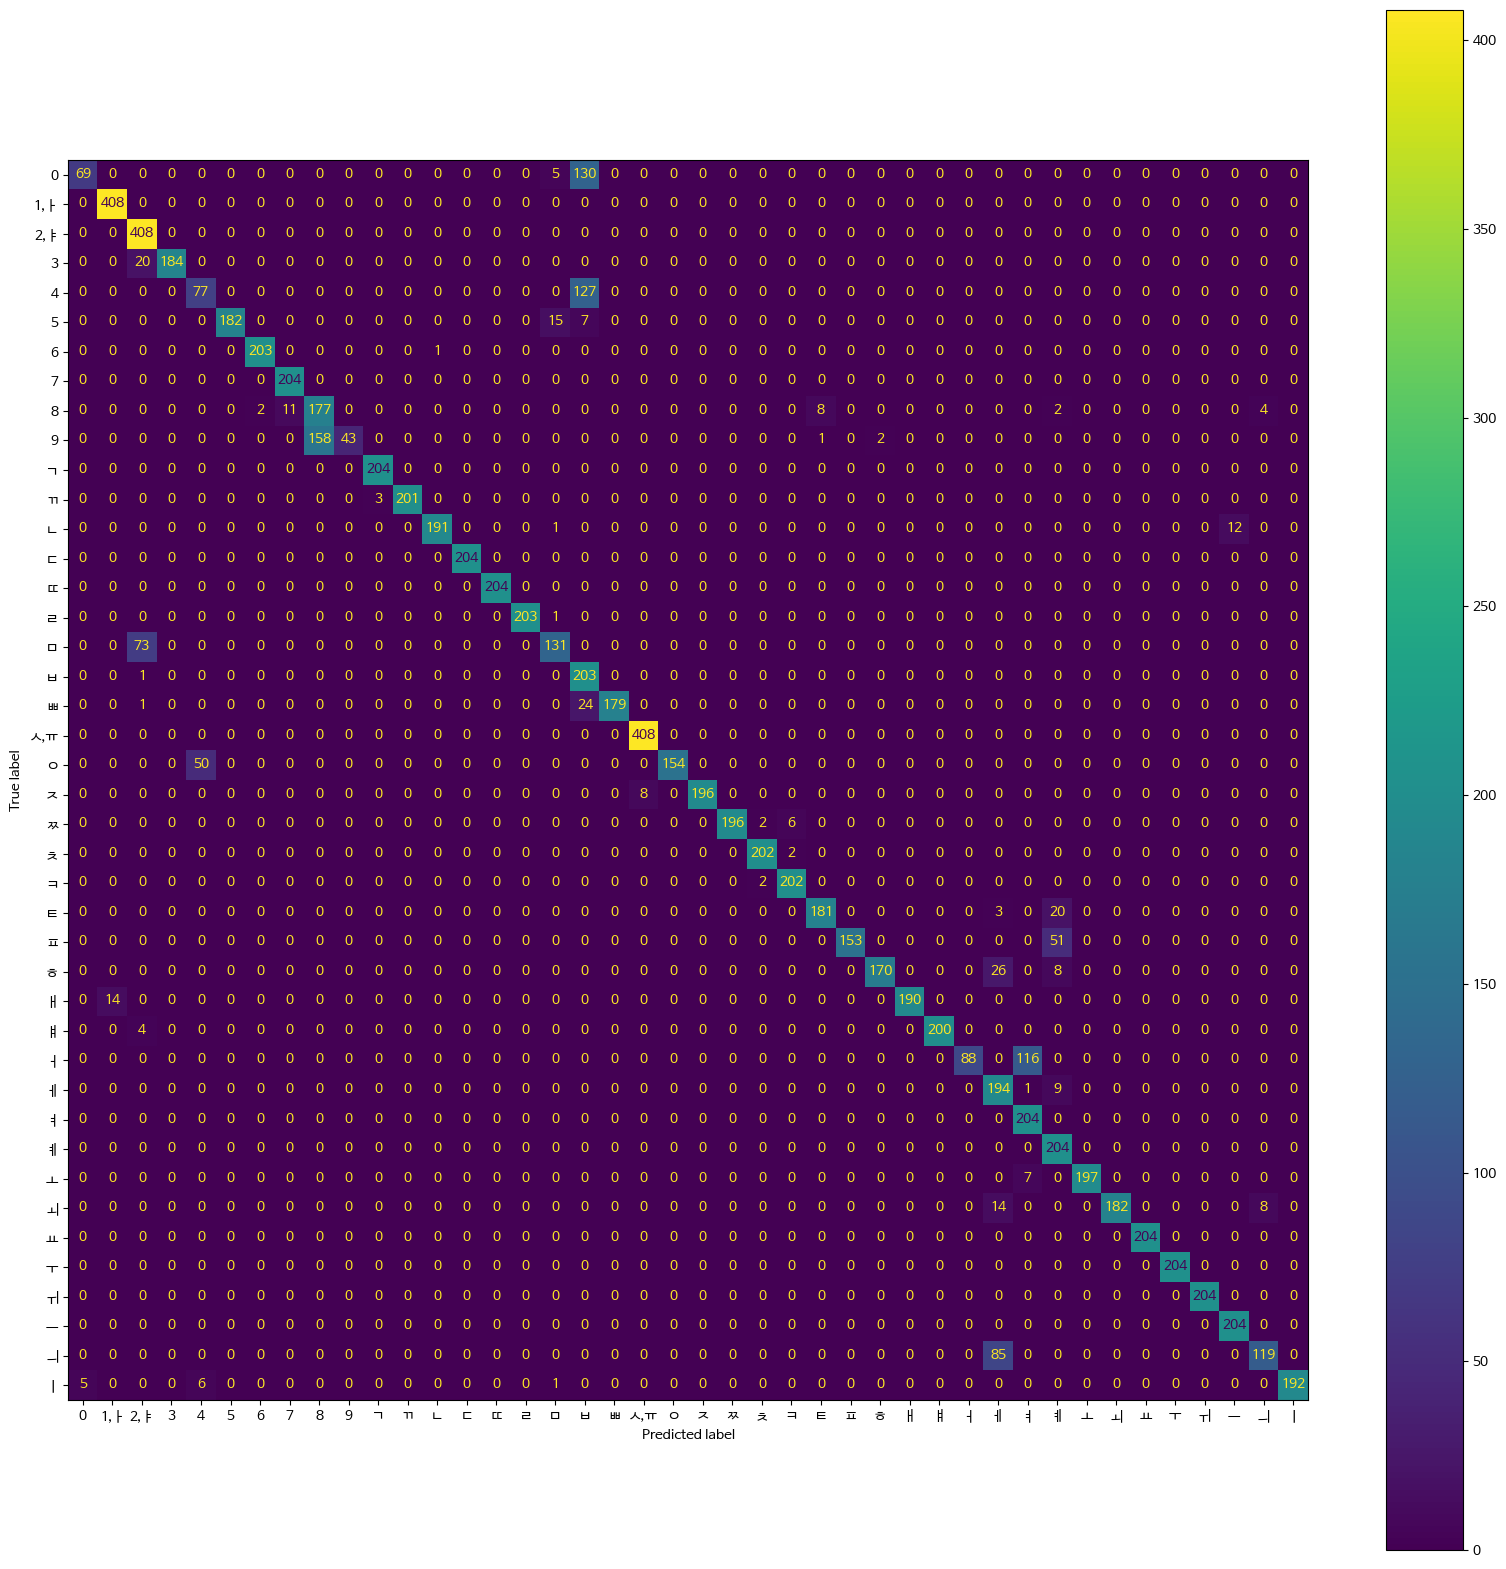

In [ ]:

# Compile hyperparameter
compile_kwargs = {
    "optimizer": 'Adam', 
    "loss": 'categorical_crossentropy',
    "metrics": ['categorical_accuracy'],
}

# fit hyperparameter
fit_kwargs = {
    "x": X_train, 
    "y": y_train,
    'batch_size': BATCH_SIZE,
    "epochs": EPOCH,
    "validation_data": (X_val, y_val)
}

optional_params = { 
    "test_data": (X_test, y_test),
    "aug_num": AUG_NUM,
    'aug_shift':SHIFT_VAL,
    'aug_rotate':ROTATE_VAL,
    'aug_scale': SCALE_VAL,
    'jitter_amount': JITTER_AMOUNT,
    "frame_num": FRAME_NUM,
}

run_name = f'double_LSTM_aug_{AUG_NUM}_frame_{FRAME_NUM}_e{EPOCH}_b{BATCH_SIZE}_2D'
run = train_with_mlflow(run_name, model, compile_kwargs, fit_kwargs, optional_params)